In [9]:
!ls /kaggle/working/lightning_logs/version_14/checkpoints/

'epoch=0-val_loss=1.3399014472961426-val_f1_score=0.8580293655395508-val_multiclass_accuracy=0.8747615814208984.ckpt'


In [57]:
# !rm -rf /kaggle/working/lightning_logs/version_1

In [ ]:
# from IPython.display import FileLink
# FileLink(r'lightning_logs/version_6/checkpoints/epoch=7-val_loss=0.7511404752731323-val_f1_score=0.9214637875556946-val_multiclass_accuracy=0.9239795207977295.ckpt')
# FileLink(r'models/version_4_averaged.ckpt')

In [10]:
!pip install lightning==2.0.8 --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 37.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.8/738.8 kB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.9 MB/s eta 0:00:00


In [11]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 6.8 MB/s eta 0:00:00


In [12]:
!pip install open_clip_torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 27.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.4 MB/s eta 0:00:00


In [13]:
!pip install torch_ema

In [14]:
from typing import List, Dict, Callable, Optional, Union, Tuple, Any

import os
import logging

import random

from copy import deepcopy
from torch_ema import ExponentialMovingAverage

import torch as th
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, Callback
from pytorch_lightning.utilities.types import STEP_OUTPUT
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from torcheval.metrics.functional import multiclass_f1_score, multiclass_accuracy
from transformers import get_linear_schedule_with_warmup

import torchvision.transforms.functional as F
import torchvision.transforms as T
import albumentations as A

import open_clip

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [15]:
pl.__version__

'2.0.4'

In [16]:
MODEL_NAME = "ViT-L-14"
PRETRAIN_DATASET = "datacomp_xl_s13b_b90k"
BATCH_SIZE = 128
HEAD_NUMBER = 4
AUGMENTATION = "hca"
FREEZE_BACKBONE = False
WARMUP_STEPS = 0
EPOCHS = 1
LABEL_SMOOTHING = 0.1
DROPOUT_RATE = 0.5
USE_LINEAR_SCHEDULE = True
USE_LAYER_NORM = True
TEST_SIZE = 0.2
USE_ZENODO_DATA = False
N_ZENODO_DATA = False
NUM_TRAINING_STEPS = 12000
USE_CLASS_WEIGHTS = False
USE_INATURALIST_DATA = False
USE_LUX = False
USE_PRETRAINED = True
HEAD_LR = 1e-3

# Models

In [17]:
class HeadV1(nn.Module):
    def __init__(self, f_out: int, f_in: int):
        super().__init__()

        self.label = nn.Sequential(
            nn.BatchNorm1d(f_in),
            nn.Dropout1d(),
            nn.LeakyReLU(),
            nn.Linear(f_in, f_out),
        )

    def forward(self, x):
        return self.label(x)


class HeadV4(nn.Module):
    def __init__(self, f_out: int, f_in: int):
        super().__init__()

        self.label = nn.Sequential(
            nn.BatchNorm1d(f_in),
            nn.Dropout1d(),
            nn.Linear(f_in, f_out),
        )

    def forward(self, x):
        return self.label(x)


class HeadV8(nn.Module):
    def __init__(self, f_out: int, f_in: int):
        super().__init__()

        self.label = nn.Sequential(
            nn.Dropout1d(),
            nn.Linear(f_in, f_out),
        )

    def forward(self, x):
        return self.label(x)


class HeadV7(nn.Module):
    def __init__(self, f_out: int, f_in: int):
        super().__init__()

        self.label = nn.Sequential(
            nn.LayerNorm(f_in),
            nn.Dropout1d(),
            nn.Linear(f_in, f_out),
        )

    def forward(self, x):
        return self.label(x)


class HeadV5(nn.Module):
    def __init__(self, f_out: int, f_in: int):
        super().__init__()

        self.label = nn.Sequential(
            nn.BatchNorm1d(f_in),
            nn.Dropout1d(p=0.9),
            nn.Linear(f_in, f_out),
        )

    def forward(self, x):
        return self.label(x)


class HeadV6(nn.Module):
    def __init__(self, f_out: int, f_in: int):
        super().__init__()

        self.label = nn.Sequential(
            nn.BatchNorm1d(f_in),
            nn.Dropout1d(p=0.75),
            nn.Linear(f_in, f_out),
        )

    def forward(self, x):
        return self.label(x)


class HeadV2(nn.Module):
    def __init__(self, f_out: int, f_in: int):
        super().__init__()

        self.label = nn.Sequential(
            nn.BatchNorm1d(f_in),
            nn.Linear(f_in, f_out),
        )

    def forward(self, x):
        return self.label(x)


class HeadV3(nn.Module):
    def __init__(self, f_out: int, f_in: int):
        super().__init__()

        self.label = nn.Sequential(
            nn.BatchNorm1d(f_in),
            nn.Linear(f_in, f_in, bias=False),
            nn.BatchNorm1d(f_in),
            nn.LeakyReLU(),
            nn.Dropout1d(),
            nn.Linear(f_in, f_in, bias=False),
            nn.BatchNorm1d(f_in),
            nn.LeakyReLU(),
            nn.Dropout1d(),
            nn.Linear(f_in, f_out),
        )

    def forward(self, x):
        return self.label(x)


class CLIPClassifier(nn.Module):
    def __init__(
        self,
        n_classes: int = 6,
        model_name: str = "ViT-L-14",
        data: str = "datacomp_xl_s13b_b90k",
        head_version: int = 1,
    ):
        super().__init__()
        self.backbone = open_clip.create_model(
            model_name, pretrained=None, device="cpu"
        ).visual

        if model_name == "ViT-L-14":
            self.n = 768
            self.lrs = dict(
                back_lrs={"8": 1.25e-6, "16": 2.5e-6, "20": 5e-6, "24": 10e-6},
                back_wd=1e-3,
                hd_lr=HEAD_LR,
                hd_wd=1e-6,
            )
        elif model_name == "ViT-H-14":
            self.n = 1024
        elif model_name == "ViT-B-16":
            self.n = 512
        else:
            raise ValueError

        if head_version == 2:
            self.label = HeadV2(n_classes, self.n)
        elif head_version == 3:
            self.label = HeadV3(n_classes, self.n)
        elif head_version == 4:
            self.label = HeadV4(n_classes, self.n)
        elif head_version == 5:
            self.label = HeadV5(n_classes, self.n)
        elif head_version == 6:
            self.label = HeadV6(n_classes, self.n)
        elif head_version == 7:
            self.label = HeadV7(n_classes, self.n)
        elif head_version == 8:
            self.label = HeadV8(n_classes, self.n)
        else:
            self.label = HeadV1(n_classes, self.n)

        self.n_classes = n_classes

    def forward(self, x: th.tensor) -> th.tensor:
        x = self.backbone(x)
        return self.label(x)

    def get_parameter_section(self, parameters, lr=None, wd=None):
        # https://github.com/IvanAer/G-Universal-CLIP
        parameter_settings = []

        lr_is_dict = isinstance(lr, dict)
        wd_is_dict = isinstance(wd, dict)

        layer_no = None
        for n, p in parameters:
            for split in n.split("."):
                if split.isnumeric():
                    layer_no = int(split)

            if not layer_no:
                layer_no = 0

            if lr_is_dict:
                for k, v in lr.items():
                    if layer_no < int(k):
                        temp_lr = v
                        break
            else:
                temp_lr = lr

            if wd_is_dict:
                for k, v in wd.items():
                    if layer_no < int(k):
                        temp_wd = v
                        break
            else:
                temp_wd = wd

            parameter_setting = {"params": p, "lr": temp_lr, "weight_decay": temp_wd}
            parameter_settings.append(parameter_setting)
        return parameter_settings

    def get_learnable_params(self) -> list:
        back_lrs = self.lrs["back_lrs"]
        back_wd = self.lrs["back_wd"]
        hd_lr = self.lrs["hd_lr"]
        hd_wd = self.lrs["hd_wd"]

        parameter_settings = []

        if back_lrs and back_wd:
            parameter_settings.extend(
                self.get_parameter_section(
                    [(n, p) for n, p in self.backbone.named_parameters()],
                    lr=back_lrs,
                    wd=back_wd,
                )
            )

        parameter_settings.extend(
            self.get_parameter_section(
                [(n, p) for n, p in self.label.named_parameters()], lr=hd_lr, wd=hd_wd
            )
        )

        return parameter_settings

# Dataloader

In [18]:
def pre_process(_: str) -> T.Compose:
    return T.Compose(
        [
            T.ToTensor(),
            T.Normalize(
                mean=(0.48145466, 0.4578275, 0.40821073),
                std=(0.26862954, 0.26130258, 0.27577711),
            ),
        ]
    )


def aug(data_aug: str = "image_net") -> T.Compose:
    transform = T.Compose(
        [
            T.ToPILImage(),
            T.Resize(
                size=(224, 224),
                interpolation=T.InterpolationMode.BICUBIC,
                antialias=True,
            ),
        ]
    )
    if data_aug == "image_net":
        transform = T.Compose(
            [
                T.ToPILImage(),
                T.AutoAugment(T.AutoAugmentPolicy.IMAGENET),
                T.Resize(
                    size=(224, 224),
                    interpolation=T.InterpolationMode.BICUBIC,
                    antialias=True,
                ),
            ]
        )

    elif data_aug == "hca":
        aug8p3 = A.OneOf(
            [
                A.Sharpen(p=0.3),
                A.ToGray(p=0.3),
                A.CLAHE(p=0.3),
            ],
            p=0.5,
        )

        blur = A.OneOf(
            [
                A.GaussianBlur(p=0.3),
                A.MotionBlur(p=0.3),
            ],
            p=0.5,
        )

        transform = A.Compose(
            [
                A.ShiftScaleRotate(
                    rotate_limit=45,
                    scale_limit=0.1,
                    border_mode=cv2.BORDER_REFLECT,
                    interpolation=cv2.INTER_CUBIC,
                    p=0.5,
                ),
                A.Resize(224, 224, cv2.INTER_CUBIC),
                aug8p3,
                blur,
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.ElasticTransform(p=0.5),
                A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
            ]
        )
    elif data_aug == "aug_mix":
        transform = T.Compose(
            [
                T.ToPILImage(),
                T.AugMix(),
                T.Resize(
                    size=(224, 224),
                    interpolation=T.InterpolationMode.BICUBIC,
                    antialias=True,
                ),
            ]
        )
    elif data_aug == "happy_whale":
        aug8p3 = A.OneOf(
            [
                A.Sharpen(p=0.3),
                A.ToGray(p=0.3),
                A.CLAHE(p=0.3),
            ],
            p=0.5,
        )

        transform = A.Compose(
            [
                A.ShiftScaleRotate(
                    rotate_limit=15,
                    scale_limit=0.1,
                    border_mode=cv2.BORDER_REFLECT,
                    p=0.5,
                ),
                A.Resize(224, 224, cv2.INTER_CUBIC),
                aug8p3,
                A.HorizontalFlip(p=0.5),
                A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
            ]
        )

    elif data_aug == "cut_out":
        transform = A.Compose(
            [
                A.HorizontalFlip(p=0.5),
                A.ImageCompression(quality_lower=99, quality_upper=100),
                A.ShiftScaleRotate(
                    shift_limit=0.2,
                    scale_limit=0.2,
                    rotate_limit=10,
                    border_mode=cv2.BORDER_REFLECT,
                    p=0.7,
                ),
                A.Resize(224, 224, cv2.INTER_CUBIC),
                A.Cutout(
                    max_h_size=int(224 * 0.4),
                    max_w_size=int(224 * 0.4),
                    num_holes=1,
                    p=0.5,
                ),
            ]
        )
    elif data_aug == "clip":
        transform = T.Compose(
            [
                T.ToPILImage(),
                T.RandomResizedCrop(
                    size=(224, 224),
                    scale=(0.9, 1.0),
                    ratio=(0.75, 1.3333),
                    interpolation=T.InterpolationMode.BICUBIC,
                    antialias=True,
                ),
                T.Resize(
                    size=(224, 224),
                    interpolation=T.InterpolationMode.BICUBIC,
                    antialias=True,
                ),
            ]
        )
    elif data_aug == "clip+image_net":
        transform = T.Compose(
            [
                T.ToPILImage(),
                T.AutoAugment(T.AutoAugmentPolicy.IMAGENET),
                T.RandomResizedCrop(
                    size=(224, 224),
                    scale=(0.9, 1.0),
                    ratio=(0.75, 1.3333),
                    interpolation=T.InterpolationMode.BICUBIC,
                    antialias=True,
                ),
                T.Resize(
                    size=(224, 224),
                    interpolation=T.InterpolationMode.BICUBIC,
                    antialias=True,
                ),
            ]
        )

    return transform


def read_image_cv2(f_name: str, gray_scale: bool = False) -> np.ndarray:
    img = cv2.imread(
        f_name, cv2.IMREAD_ANYCOLOR if not gray_scale else cv2.IMREAD_GRAYSCALE
    )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def class_balancing(df: pd.DataFrame) -> pd.DataFrame:
    counts = df.class_label.value_counts().to_dict()
    max_label = max(list(counts.items()), key=lambda x: x[1])

    for key, value in counts.items():
        if key == max_label[0]:
            continue

        df_label = df[df.class_label == key].sample(
            n=max_label[1] - value, replace=True
        )
        df = pd.concat([df, df_label])

    return df


class SimpleClassificationDataset(Dataset):
    def __init__(
        self,
        annotations_df: pd.DataFrame,
        img_dir: str,
        class_dict: dict,
        transform: Optional[T.Compose] = None,
        data_augment: Optional[Union[T.Compose, A.Compose]] = None,
        class_balance: bool = True,
    ):
        self.df = annotations_df
        if class_balance:
            self.df = class_balancing(annotations_df)

        self.img_dir = img_dir
        self.class_dict = class_dict
        self.transform = transform
        self.data_augment = data_augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        cv2.setNumThreads(6)

        f_name, _, _, x_tl, y_tl, x_br, y_br, label = self.df.iloc[idx]

        img = read_image_cv2(os.path.join(self.img_dir, f_name))
        img_ = img[y_tl:y_br, x_tl:x_br, :]
        if img_.shape[0] * img_.shape[1] != 0:
            img = img_

        if self.data_augment:
            if isinstance(self.data_augment, A.Compose):
                img = self.data_augment(image=img)["image"]
            else:
                img = self.data_augment(img)

        if self.transform:
            img = self.transform(img)

        if self.class_dict:
            label = self.class_dict[label]
        return {"img": img, "label": label}

# Classification

In [19]:
def f1(y_true: th.Tensor, y_pred: th.Tensor):
    y_pred = th.round(y_pred)
    tp = th.sum((y_true * y_pred).float(), dim=0)
    tn = th.sum(((1 - y_true) * (1 - y_pred)).float(), dim=0)
    fp = th.sum(((1 - y_true) * y_pred).float(), dim=0)
    fn = th.sum((y_true * (1 - y_pred)).float(), dim=0)

    p = tp / (tp + fp + 1e-7)
    r = tp / (tp + fn + 1e-7)

    f1 = 2 * p * r / (p + r + 1e-7)
    f1 = th.where(th.isnan(f1), th.zeros_like(f1), f1)
    return th.mean(f1)


def f1_loss(y_true: th.Tensor, y_pred: th.Tensor):
    tp = th.sum((y_true * y_pred).float(), dim=0)
    tn = th.sum(((1 - y_true) * (1 - y_pred)).float(), dim=0)
    fp = th.sum(((1 - y_true) * y_pred).float(), dim=0)
    fn = th.sum((y_true * (1 - y_pred)).float(), dim=0)

    p = tp / (tp + fp + 1e-7)
    r = tp / (tp + fn + 1e-7)

    f1 = 2 * p * r / (p + r + 1e-7)
    f1 = th.where(th.isnan(f1), th.zeros_like(f1), f1)
    return 1 - th.mean(f1)


def accuracy(y1: th.Tensor, y2: th.Tensor):
    y1_argmax = y1.argmax(dim=1)
    y2_argmax = y2.argmax(dim=1)

    correct_sum = th.sum(y1_argmax == y2_argmax)
    return correct_sum / len(y1)


class MosquitoClassifier(pl.LightningModule):
    def __init__(
        self,
        n_classes: int = 6,
        model_name: str = "ViT-L-14",
        dataset: str = "datacomp_xl_s13b_b90k",
        freeze_backbones: bool = False,
        head_version: int = 0,
        warm_up_steps: int = 2000,
        bs: int = 64,
        data_aug: str = "",
        loss_func: str = "ce",
        epochs: int = 5,
        class_weight = th.ones(6)
    ):
        super().__init__()
        self.save_hyperparameters()

        self.cls = CLIPClassifier(n_classes, model_name, dataset, head_version)
        if freeze_backbones:
            self.freezebackbone()

        self.scheduler = None
        self.n_classes = n_classes
        self.warm_up_steps = warm_up_steps
        self.loss_func = loss_func
        self.class_weight = class_weight.cuda()

        self.val_labels_t = []
        self.val_labels_p = []

        self.train_labels_t = []
        self.train_labels_p = []

    def freezebackbone(self) -> None:
        for param in self.cls.backbone.parameters():
            param.requires_grad = False

    def forward(self, x: th.Tensor) -> th.Tensor:
        return self.cls(x)

    def lr_schedulers(self):
        # over-write this shit
        return self.scheduler

    def configure_optimizers(self):
        optimizer = th.optim.AdamW(self.cls.get_learnable_params())
        if USE_LINEAR_SCHEDULE:
            self.scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=self.warm_up_steps,
                num_training_steps=NUM_TRAINING_STEPS,  # not sure what to set
            )
        return optimizer

    def compute_loss(self, label_t: th.Tensor, label_p: th.Tensor) -> th.Tensor:
        if self.loss_func == "f1":
            label_loss = f1_loss(label_t, th.nn.functional.softmax(label_p, dim=1))
        elif self.loss_func == "ce+f1":
            label_loss = f1_loss(
                label_t, th.nn.functional.softmax(label_p, dim=1)
            ) + nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING, weight=self.class_weight)(label_p, label_t)
        else:
            label_loss = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING, weight=self.class_weight)(label_p, label_t)

        return label_loss

    def training_step(self, train_batch, batch_idx) -> STEP_OUTPUT:
        img, label_t = (
            train_batch["img"],
            train_batch["label"],
        )

        label_p = self.cls(img)
        label_loss = self.compute_loss(label_t, label_p)

        self.train_labels_t.append(label_t.detach().cpu())
        self.train_labels_p.append(label_p.detach().cpu())

        self.log("train_loss", label_loss, prog_bar=True)

        if self.scheduler is not None:
            self.scheduler.step()

        return label_loss

    def on_train_epoch_end(self) -> None:
        label_p = th.concatenate(self.train_labels_p)
        label_t = th.concatenate(self.train_labels_t)

        self.log_dict(
            {
                "train_f1_score": multiclass_f1_score(
                    label_p,
                    label_t.argmax(dim=1),
                    num_classes=self.n_classes,
                    average="macro",
                ),
                "train_multiclass_accuracy": multiclass_accuracy(
                    label_p,
                    label_t.argmax(dim=1),
                    num_classes=self.n_classes,
                    average="macro",
                ),
                "train_accuracy": accuracy(label_t, label_p),
            }
        )

        self.train_labels_t = []
        self.train_labels_p = []

    def validation_step(self, val_batch, batch_idx) -> STEP_OUTPUT:
        img, label_t = (
            val_batch["img"],
            val_batch["label"],
        )

        label_p = self.cls(img)
        label_loss = self.compute_loss(label_t, label_p)

        self.val_labels_t.append(label_t.detach().cpu())
        self.val_labels_p.append(label_p.detach().cpu())

        self.log("val_loss", label_loss, prog_bar=True)

        return label_loss

    def on_validation_epoch_end(self):
        label_p = th.concatenate(self.val_labels_p)
        label_t = th.concatenate(self.val_labels_t)

        self.log_dict(
            {
                "val_f1_score": multiclass_f1_score(
                    label_p,
                    label_t.argmax(dim=1),
                    num_classes=self.n_classes,
                    average="macro",
                ),
                "val_multiclass_accuracy": multiclass_accuracy(
                    label_p,
                    label_t.argmax(dim=1),
                    num_classes=self.n_classes,
                    average="macro",
                ),
                "val_accuracy": accuracy(label_t, label_p),
            }
        )

        self.val_labels_t = []
        self.val_labels_p = []

    def on_epoch_end(self):
        opt = self.optimizers(use_pl_optimizer=True)
        self.log("lr", opt.param_groups[0]["lr"])
        
class EMA(nn.Module):
    """Model Exponential Moving Average V2 from timm"""

    def __init__(self, model: nn.Module, decay: float = 0.9999):
        super(EMA, self).__init__()
        # make a copy of the model for accumulating moving average of weights
        self.module = deepcopy(model)
        self.module.eval()
        self.decay = decay

    def _update(self, model: nn.Module, update_fn):
        with th.no_grad():
            for ema_v, model_v in zip(
                self.module.state_dict().values(), model.state_dict().values()
            ):
                ema_v.copy_(update_fn(ema_v, model_v))

    def update(self, model):
        self._update(
            model, update_fn=lambda e, m: self.decay * e + (1.0 - self.decay) * m
        )

    def set(self, model):
        self._update(model, update_fn=lambda e, m: m)


class MosquitoClassifier(pl.LightningModule):
    def __init__(
        self,
        n_classes: int = 6,
        model_name: str = "ViT-L-14",
        dataset: str = None,
        head_version: int = 0,
        use_ema: bool = False,
    ):
        super().__init__()
        if dataset == "imagenet":
            self.cls = build_covnext(model_name, n_classes)

        else:
            self.cls = CLIPClassifier(n_classes, model_name, dataset, head_version)

        self.use_ema = use_ema
        if use_ema:
            self.ema = EMA(self.cls, decay=0.995)
            
        self.freezebackbone()
        self.scheduler = None
        self.n_classes = n_classes
        self.warm_up_steps = WARMUP_STEPS
        self.loss_func = "ce+f1"
        self.class_weight = th.ones(6).cuda()
        self.val_labels_t = []
        self.val_labels_p = []
        self.train_labels_t = []
        self.train_labels_p = []

    def forward(self, x: th.Tensor) -> th.Tensor:
        if self.use_ema and not self.training:
            print("Using EMA...")
            return self.ema.module(x)
        return self.cls(x)
    
    def freezebackbone(self) -> None:
        for param in self.cls.backbone.parameters():
            param.requires_grad = False

    def lr_schedulers(self):
        # over-write this shit
        return self.scheduler

    def configure_optimizers(self):
        optimizer = th.optim.AdamW(self.cls.get_learnable_params())
        if USE_LINEAR_SCHEDULE:
            self.scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=self.warm_up_steps,
                num_training_steps=NUM_TRAINING_STEPS,  # not sure what to set
            )
        return optimizer
    
    def compute_loss(self, label_t: th.Tensor, label_p: th.Tensor) -> th.Tensor:
        if self.loss_func == "f1":
            label_loss = f1_loss(label_t, th.nn.functional.softmax(label_p, dim=1))
        elif self.loss_func == "ce+f1":
            label_loss = f1_loss(
                label_t, th.nn.functional.softmax(label_p, dim=1)
            ) + nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING, weight=self.class_weight)(label_p, label_t)
        else:
            label_loss = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING, weight=self.class_weight)(label_p, label_t)

        return label_loss

    def training_step(self, train_batch, batch_idx) -> STEP_OUTPUT:
        img, label_t = (
            train_batch["img"],
            train_batch["label"],
        )

        label_p = self.cls(img)
        label_loss = self.compute_loss(label_t, label_p)

        self.train_labels_t.append(label_t.detach().cpu())
        self.train_labels_p.append(label_p.detach().cpu())

        self.log("train_loss", label_loss, prog_bar=True)

        if self.scheduler is not None:
            self.scheduler.step()

        return label_loss
    
    def on_train_epoch_end(self) -> None:
        label_p = th.concatenate(self.train_labels_p)
        label_t = th.concatenate(self.train_labels_t)

        self.log_dict(
            {
                "train_f1_score": multiclass_f1_score(
                    label_p,
                    label_t.argmax(dim=1),
                    num_classes=self.n_classes,
                    average="macro",
                ),
                "train_multiclass_accuracy": multiclass_accuracy(
                    label_p,
                    label_t.argmax(dim=1),
                    num_classes=self.n_classes,
                    average="macro",
                ),
                "train_accuracy": accuracy(label_t, label_p),
            }
        )

        self.train_labels_t = []
        self.train_labels_p = []
    
    def validation_step(self, val_batch, batch_idx) -> STEP_OUTPUT:
        img, label_t = (
            val_batch["img"],
            val_batch["label"],
        )

        label_p = self.cls(img)
        label_loss = self.compute_loss(label_t, label_p)

        self.val_labels_t.append(label_t.detach().cpu())
        self.val_labels_p.append(label_p.detach().cpu())

        self.log("val_loss", label_loss, prog_bar=True)

        return label_loss
    
    def on_validation_epoch_end(self):
        label_p = th.concatenate(self.val_labels_p)
        label_t = th.concatenate(self.val_labels_t)

        self.log_dict(
            {
                "val_f1_score": multiclass_f1_score(
                    label_p,
                    label_t.argmax(dim=1),
                    num_classes=self.n_classes,
                    average="macro",
                ),
                "val_multiclass_accuracy": multiclass_accuracy(
                    label_p,
                    label_t.argmax(dim=1),
                    num_classes=self.n_classes,
                    average="macro",
                ),
                "val_accuracy": accuracy(label_t, label_p),
            }
        )

        self.val_labels_t = []
        self.val_labels_p = []

    def on_epoch_end(self):
        opt = self.optimizers(use_pl_optimizer=True)
        self.log("lr", opt.param_groups[0]["lr"])


# Experiments

In [20]:
def _default_callbacks() -> List[Callback]:
    return [
        ModelCheckpoint(
            monitor="val_f1_score",
            mode="max",
            save_top_k=3,
            save_last=False,
            filename="{epoch}-{val_loss}-{val_f1_score}-{val_multiclass_accuracy}",
            save_weights_only=True
        ),
        
    ]


CLASS_DICT = {
    "albopictus": th.tensor([1, 0, 0, 0, 0, 0], dtype=th.float),
    "culex": th.tensor([0, 1, 0, 0, 0, 0], dtype=th.float),
    "japonicus/koreicus": th.tensor([0, 0, 1, 0, 0, 0], dtype=th.float),
    "culiseta": th.tensor([0, 0, 0, 1, 0, 0], dtype=th.float),
    "anopheles": th.tensor([0, 0, 0, 0, 1, 0], dtype=th.float),
    "aegypti": th.tensor([0, 0, 0, 0, 0, 1], dtype=th.float),
}


class ExperimentMosquitoClassifier:
    def __init__(
        self,
        img_dir: str,
        annotations_df: pd.DataFrame,
        class_dict: Dict[str, th.Tensor] = CLASS_DICT,
    ):
        self.img_dir = img_dir
        self.annotations_df = annotations_df
        self.class_dict = class_dict

    def get_dataloaders(
        self,
        train_df: pd.DataFrame,
        val_df: pd.DataFrame,
        model_name: str,
        data_aug: str,
        bs: int,
    ) -> List[DataLoader]:
        transform = pre_process(model_name)

        train_dataset = SimpleClassificationDataset(
            train_df,
            self.img_dir,
            self.class_dict,
            transform,
            aug(data_aug),
            class_balance=False,
        )
        train_dataloader = DataLoader(
            train_dataset,
            batch_size=bs,
            shuffle=True,
            num_workers=4,
            drop_last=True,
        )

        val_dataset = SimpleClassificationDataset(
            val_df,
            self.img_dir,
            self.class_dict,
            transform,
            aug("resize"),
            class_balance=False,
        )
        val_dataloader = DataLoader(
            val_dataset,
            batch_size=bs,
            shuffle=False,
            num_workers=4,
        )

        return train_dataloader, val_dataloader

    def run(
        self,
        model_name: str,
        dataset: str,
        bs: int,
        head_version: int,
        data_aug: str,
        freeze_backbones: bool = False,
        warm_up_steps: int = 2000,
        epochs: int = 5,
        create_callbacks: Callable[[], List[Callback]] = _default_callbacks,
    ):
        # Challenge data
        annotations_challenge = self.annotations_df[self.annotations_df['img_fName'].str.contains(r"train_\d+.jpeg")]
        # annotations_challenge = self.annotations_df
        
        train_df, val_df = train_test_split(
            annotations_challenge,
            test_size=TEST_SIZE,
            stratify=annotations_challenge["class_label"],
            random_state=200,
        )
        
        if USE_ZENODO_DATA or USE_INATURALIST_DATA or USE_LUX:
            train_df = pd.concat([train_df, self.annotations_df[~self.annotations_df['img_fName'].str.contains(r"train_\d+.jpeg")]])
        else:
            train_df = class_balancing(train_df)
        
        if USE_CLASS_WEIGHTS:
            class_weight = compute_class_weight(class_weight='balanced', classes=np.array(list(CLASS_DICT.keys())), y=train_df['class_label'].to_numpy())
            class_weight = th.tensor(class_weight, dtype=th.float)
        else:
            class_weight = th.ones(6)
        print(class_weight)
        
        print(train_df["class_label"].value_counts())
        print(val_df["class_label"].value_counts())

        train_dataloader, val_dataloader = self.get_dataloaders(
            train_df, val_df, model_name, data_aug, bs
        )

        th.set_float32_matmul_precision("high")
        if not USE_PRETRAINED:
            model = MosquitoClassifier(
                model_name=model_name,
                dataset=dataset,
                freeze_backbones=freeze_backbones,
                head_version=head_version,
                warm_up_steps=warm_up_steps,
                bs=bs,
                data_aug=data_aug,
                epochs=epochs,
                class_weight=class_weight
            )
        else:
            clip_model_path = "/kaggle/input/mosquito-base-model/epoch11-val_loss0.7277861833572388-val_f1_score0.8598743081092834-val_multiclass_accuracy0.8671819567680359.ckpt"
            # model = MosquitoClassifier.load_from_checkpoint(
            # clip_model_path, head_version=4, freeze_backbones=True, loss_function="ce+f1", map_location=th.device("cuda"))
            model = MosquitoClassifier.load_from_checkpoint(clip_model_path)
        trainer = pl.Trainer(
            accelerator="gpu",
            precision="16-mixed",
            max_epochs=epochs,
            logger=True,
            deterministic=True,  # maybe we should add this
            callbacks=create_callbacks(),
        )

        trainer.fit(
            model=model,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader,
        )

In [21]:
img_dir = "/kaggle/input/mosquito-data-round-2/phase2_train_v0/final/"
annotations_csv = "/kaggle/input/mosquito-data-round-2/phase2_train_v0_cleaned_yolo_best_annotations.csv"
annotations_df = pd.read_csv(annotations_csv)
annotations_df["bbx_xtl"] = annotations_df["bbx_xtl"].astype(int)
annotations_df["bbx_ytl"] = annotations_df["bbx_ytl"].astype(int)
annotations_df["bbx_xbr"] = annotations_df["bbx_xbr"].astype(int)
annotations_df["bbx_ybr"] = annotations_df["bbx_ybr"].astype(int)

zenodo_img_dir = "/kaggle/input/zenodo-images/zenodo/images/"
zenodo_annotations_csv = "/kaggle/input/zenodo-images/zenodo/zenodo_annotations.csv"
if USE_ZENODO_DATA:
    annotations_df['img_fName'] = img_dir+annotations_df['img_fName']
    img_dir = '.'
    zenodo_annotations_df = pd.read_csv(zenodo_annotations_csv)
    zenodo_annotations_df['img_fName'] = zenodo_annotations_df['img_fName'].str.replace('zenodo_', '')
    zenodo_annotations_df['img_fName'] = zenodo_img_dir + zenodo_annotations_df['img_fName']
    if N_ZENODO_DATA:
        zenodo_annotations_df = zenodo_annotations_df.sample(n=N_ZENODO_DATA, random_state=200)
    annotations_df = pd.concat([annotations_df, zenodo_annotations_df])

inat_img_dir = "/kaggle/input/inaturalist-mosquito/inaturalist_crawler_data_all_cleaned_sub/"
inat_annotations_csv = inat_img_dir+"inaturalist.csv"
if USE_INATURALIST_DATA:
    annotations_df['img_fName'] = img_dir+annotations_df['img_fName']
    img_dir = '.'
    inat_annotations_df = pd.read_csv(inat_annotations_csv)
    inat_annotations_df = inat_annotations_df[inat_annotations_df['class_label']!='culex']
    inat_annotations_df = inat_annotations_df[inat_annotations_df['class_label']!='albopictus']
    inat_annotations_df['img_fName'] = inat_img_dir + inat_annotations_df['img_fName']
    annotations_df = pd.concat([annotations_df, inat_annotations_df])

In [22]:
lux_dir1 = "/kaggle/input/lux-dataset-annotated/gbif-cropped/"
lux_dir2 = "/kaggle/input/lux-dataset-annotated/inaturalist-six-cropped/"
lux_an_csv1 = "/kaggle/input/lux-dataset-annotated/gbif-cropped/inaturalist.csv"
lux_an_csv2 = "/kaggle/input/lux-dataset-annotated/inaturalist-six-cropped/inaturalist.csv"
if USE_LUX:
    annotations_df['img_fName'] = img_dir+annotations_df['img_fName']
    img_dir = '.'
    lux1_annotations_df = pd.read_csv(lux_an_csv1)
    lux1_annotations_df['img_fName'] = lux_dir1 + lux1_annotations_df['img_fName']
    # lux1_annotations_df = lux1_annotations_df[lux1_annotations_df['class_label']!='culex']
    # lux1_annotations_df = lux1_annotations_df[lux1_annotations_df['class_label']!='albopictus']
    lux2_annotations_df = pd.read_csv(lux_an_csv2)
    lux2_annotations_df['img_fName'] = lux_dir2 + lux2_annotations_df['img_fName']
    lux2_annotations_df = lux2_annotations_df[lux2_annotations_df['class_label']!='culex']
    lux2_annotations_df = lux2_annotations_df[lux2_annotations_df['class_label']!='albopictus']
    annotations_df = pd.concat([annotations_df, lux1_annotations_df, lux2_annotations_df])
    lux1_annotations_df.head()

In [23]:
print(annotations_df["class_label"].value_counts())

albopictus            4620
culex                 4563
culiseta               622
japonicus/koreicus     429
anopheles               84
aegypti                 47
Name: class_label, dtype: int64


/tmp/ipykernel_32/1745244140.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_bbox = th.tensor(


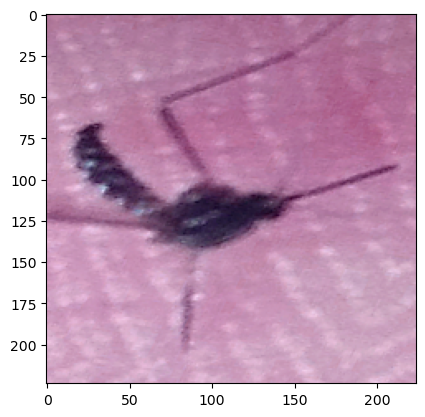

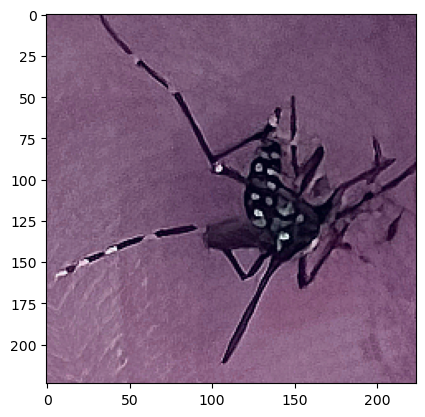

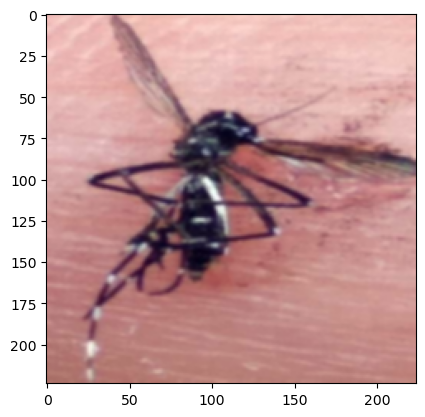

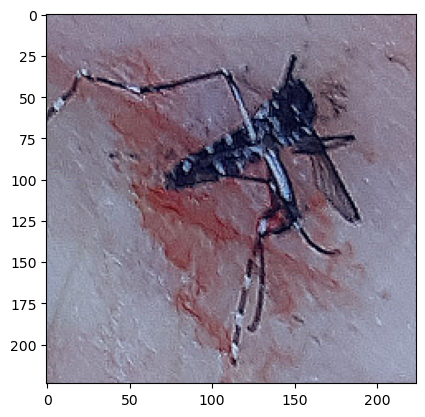

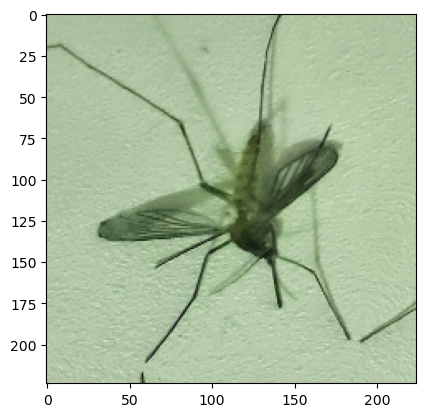

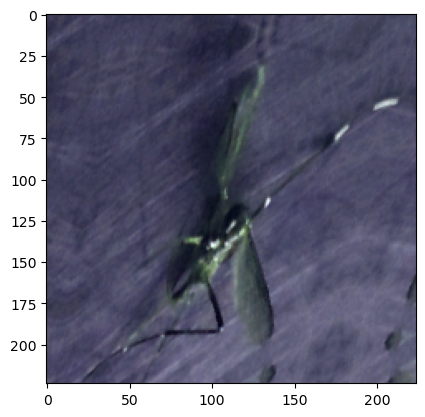

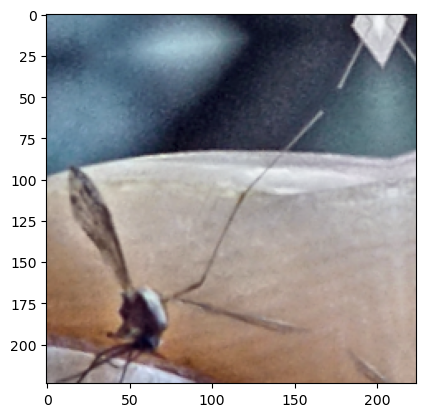

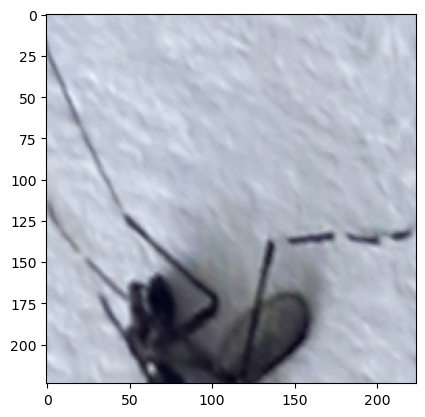

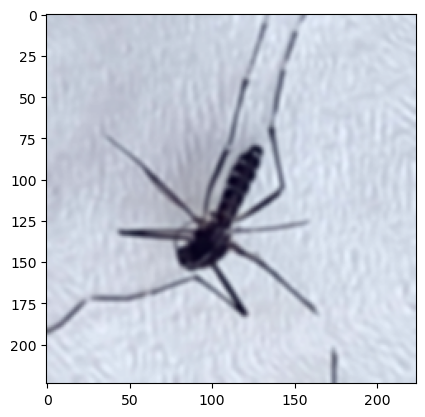

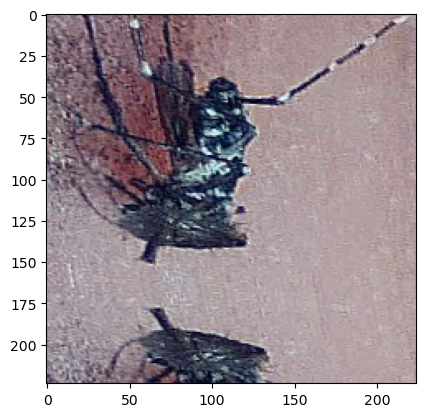

In [24]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))

class_dict = {
    "albopictus": th.tensor([1, 0, 0, 0, 0, 0], dtype=th.long),
    "culex": th.tensor([0, 1, 0, 0, 0, 0], dtype=th.long),
    "japonicus/koreicus": th.tensor([0, 0, 1, 0, 0, 0], dtype=th.long),
    "culiseta": th.tensor([0, 0, 0, 1, 0, 0], dtype=th.long),
    "anopheles": th.tensor([0, 0, 0, 0, 1, 0], dtype=th.long),
    "aegypti": th.tensor([0, 0, 0, 0, 0, 1], dtype=th.long),
}

transform = pre_process("")

data_augmentation = aug("hca")

ds = SimpleClassificationDataset(
    annotations_df=annotations_df,
    img_dir=img_dir,
    class_dict=class_dict,
    transform=transform,
    data_augment=data_augmentation,
)
for i in range(10):
    res = ds[i]
    img = res["img"]

    img_bbox = th.tensor(
        255 * (img - img.min()) / (img.max() - img.min()), dtype=th.uint8
    )
    show(img_bbox)
    plt.show()

In [25]:
exp = ExperimentMosquitoClassifier(img_dir, annotations_df)

In [ ]:
exp.run(
    model_name = MODEL_NAME,
    dataset = PRETRAIN_DATASET,
    bs = BATCH_SIZE,
    head_version = HEAD_NUMBER,
    data_aug = AUGMENTATION,
    freeze_backbones = FREEZE_BACKBONE,
    warm_up_steps = WARMUP_STEPS,
    epochs = EPOCHS)

tensor([1., 1., 1., 1., 1., 1.])
albopictus            3696
culex                 3696
culiseta              3696
japonicus/koreicus    3696
aegypti               3696
anopheles             3696
Name: class_label, dtype: int64
albopictus            924
culex                 913
culiseta              124
japonicus/koreicus     86
anopheles              17
aegypti                 9
Name: class_label, dtype: int64


/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:51: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.8, which is newer than your current Lightning version: v2.0.4
  rank_zero_warn(


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/torcheval/metrics/functional/classification/accuracy.py:275: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:224.)
  num_correct = mask.new_zeros(num_classes).scatter_(0, target, mask, reduce="add")


Training: 0it [00:00, ?it/s]

# Model Soup

In [ ]:
class MosquitoClassifier(pl.LightningModule):
    def __init__(
        self,
        n_classes: int = 6,
        model_name: str = "ViT-L-14",
        dataset: str = None,
        head_version: int = 0,
    ):
        super().__init__()
        self.cls = CLIPClassifier(n_classes, model_name, dataset, head_version)

    def forward(self, x: th.Tensor) -> th.Tensor:
        return self.cls(x)

In [ ]:
import torch

def model_soup(path_list: List[str], save_path: str):
    # Load models weights
    weight_list = []

    for path in path_list:
        print(f"Loading {path}...")
        model = MosquitoClassifier.load_from_checkpoint(
            path, map_location=torch.device("cpu")
        )
        weight_list.append(model.state_dict())

    # Average weights
    state_dict = {}

    for k in weight_list[0]:
        try:
            w = torch.stack([v[k] for v in weight_list]).mean(0)
            print(f"Mean: Layer {k}...")
        except:
            w = torch.stack([v[k] for v in weight_list]).sum(0)
            print(f"Sum: Layer {k}...")

        state_dict[k] = w
    model.load_state_dict(state_dict)

    trainer = pl.Trainer()
    trainer.strategy.connect(model)
    trainer.save_checkpoint(save_path)
    

In [ ]:
model_names = [
    '/kaggle/working/lightning_logs/version_4/checkpoints/epoch=5-val_loss=0.7609413266181946-val_f1_score=0.8209875226020813-val_multiclass_accuracy=0.7888965606689453.ckpt',
    '/kaggle/working/lightning_logs/version_4/checkpoints/epoch=7-val_loss=0.7274188995361328-val_f1_score=0.8357369303703308-val_multiclass_accuracy=0.8175098896026611.ckpt' 
]

model_soup(model_names, "/kaggle/working/models/version_4_averaged.ckpt")

In [ ]:
model_names = [
    '/kaggle/working/lightning_logs/version_3/checkpoints/epoch=5-val_loss=0.7001691460609436-val_f1_score=0.8165072798728943-val_multiclass_accuracy=0.7728392481803894.ckpt',
    '/kaggle/working/lightning_logs/version_4/checkpoints/epoch=7-val_loss=0.7274188995361328-val_f1_score=0.8357369303703308-val_multiclass_accuracy=0.8175098896026611.ckpt' 
]

model_soup(model_names, "/kaggle/working/models/version_34_averaged.ckpt")

# Bounding Boxes

In [ ]:
import torch
import os
from pathlib import Path
import cv2
from timeit import default_timer as timer
import timeit
import time
import pandas as pd
from tqdm.auto import tqdm
import requests
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from transformers import OwlViTProcessor, OwlViTForObjectDetection

In [ ]:
owl_processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32", cache_dir='models/owl/')
owl_model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32", cache_dir='models/owl/').cpu()

In [ ]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
texts = [["a photo of a mosquito"]]


In [ ]:
s = time.time()
with torch.no_grad():
    inputs = owl_processor(text=texts, images=image, padding='do_not_pad', return_tensors="pt")
    outputs = owl_model(**inputs)
    target_sizes = torch.Tensor([image.size[::-1]])

    # Convert outputs (bounding boxes and class logits) to COCO API
    results = owl_processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.01)
e = time.time()
print("OWL Time ", 1000 * (e - s), "ms")

In [ ]:
@torch.no_grad()
def locate_object():
    # inputs = owl_processor(text=texts, images=image, padding='do_not_pad', return_tensors="pt")
    inputs = owl_processor(text=texts, images=image, return_tensors="pt")
    outputs = owl_model(**inputs)
    target_sizes = torch.Tensor([image.size[::-1]])

    # Convert outputs (bounding boxes and class logits) to COCO API
    results = owl_processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.01)

timeit.timeit(locate_object, number=20)

In [ ]:
with torch.no_grad():
    text_tokens = owl_processor(text=texts, return_tensors="pt")

@torch.no_grad()
def locate_object():
    # inputs = owl_processor(text=texts, images=image, padding='do_not_pad', return_tensors="pt")
    # inputs = owl_processor(text=texts, images=image, return_tensors="pt")
    outputs = owl_model(**text_tokens, **owl_processor.image_processor(images=image, return_tensors="pt", size=768))
    target_sizes = torch.Tensor([image.size[::-1]])

    # Convert outputs (bounding boxes and class logits) to COCO API
    results = owl_processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.01)

timeit.timeit(locate_object, number=20)

In [ ]:
from transformers import YolosImageProcessor, YolosForObjectDetection
from PIL import Image
import torch
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
image_processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# model predicts bounding boxes and corresponding COCO classes
logits = outputs.logits
bboxes = outputs.pred_boxes


# print results
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

In [ ]:
img_dir = "/kaggle/input/mosquito-data-round-2/phase2_train_v0/final/"
annotations_csv = "/kaggle/input/mosquito-data-round-2/phase2_train_v0.csv"
root_images = os.path.join(img_dir)

all_images = os.listdir(root_images)
print(f"Total images: {len(all_images)}")

In [ ]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [ ]:
image.size

In [ ]:
original_image_file = os.path.join(root_images, all_images[3])
image = Image.open(original_image_file)

with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

# model predicts bounding boxes and corresponding COCO classes
logits = outputs.logits
bboxes = outputs.pred_boxes


# print results
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.1, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )
results['iou'] = np.array([bb_intersection_over_union(box.tolist(), [0, 0, *image.size]) for box in results["boxes"]])
print(results['iou'])
results["scores"] = results["scores"][results['iou']<0.95]
results["boxes"] = results["boxes"][results['iou']<0.95]
    
best_score_index = np.argmax(results["scores"].numpy())
box = results["boxes"][best_score_index]

In [ ]:
# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

# Create a Rectangle patch
box = [round(i, 2) for i in box.tolist()]
rect_owl = patches.Rectangle(box[:2], box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none', label='Owl-ViT')
ax.add_patch(rect_owl)
plt.legend()
plt.axis('off')

plt.show()

In [ ]:
owl_processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32", cache_dir='models/owl/')
owl_model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32", cache_dir='models/owl/').cuda()

In [ ]:
img_dir = "/kaggle/input/mosquito-data-round-2/phase2_train_v0/final/"
annotations_csv = "/kaggle/input/mosquito-data-round-2/phase2_train_v0.csv"

In [ ]:
root_images = os.path.join(img_dir)

all_images = os.listdir(root_images)
print(f"Total images: {len(all_images)}")

In [ ]:
rows = []
for original_image in tqdm(all_images):
    original_image_file = os.path.join(root_images, original_image)
    image = Image.open(original_image_file)
    with torch.no_grad():
        texts = [["a photo of a mosquito"]]
        inputs = owl_processor(text=texts, images=image, return_tensors="pt").to('cuda')
        outputs = owl_model(**inputs)
        # Target image sizes (height, width) to rescale box predictions [batch_size, 2]
        target_sizes = torch.Tensor([image.size[::-1]]).to('cuda')

        # Convert outputs (bounding boxes and class logits) to COCO API
        results = owl_processor.post_process_object_detection(outputs=outputs, 
                                                            target_sizes=target_sizes, 
                                                            threshold=0.01)
        
        i = 0  # Retrieve predictions for the first image for the corresponding text queries
        text = texts[i]
        boxes, scores, labels = results[i]["boxes"].cpu().numpy(), results[i]["scores"].cpu().numpy(), results[i]["labels"].cpu().numpy()
        best_score_index = np.argmax(scores)
        boxes, scores, labels = boxes[best_score_index], scores[best_score_index], labels[best_score_index]
        row = [original_image, boxes[0], boxes[1], boxes[2], boxes[3]]
        rows.append(row)

In [ ]:
df = pd.DataFrame(rows, columns=["img_fName", "bbx_xtl", "bbx_ytl", "bbx_xbr", "bbx_ybr"])
df.to_csv('/kaggle/working/owl_vit_image_bboxes.csv', index=False)
df.head()

In [ ]:
annotations_df = pd.read_csv(annotations_csv)
annotations_df.head()

In [ ]:
df_merged = annotations_df.merge(df, on='img_fName', how='left')

In [ ]:
df_merged['bbox_true'] = df_merged.apply(lambda x: [x.bbx_xtl_x, x.bbx_ytl_x, x.bbx_xbr_x, x.bbx_ybr_x], axis=1)
df_merged['bbox_owl'] = df_merged.apply(lambda x: [x.bbx_xtl_y, x.bbx_ytl_y, x.bbx_xbr_y, x.bbx_ybr_y], axis=1)

In [ ]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou


In [ ]:
df_merged['IoU'] = df_merged.apply(lambda x: bb_intersection_over_union(x.bbox_true, x.bbox_owl), axis=1)

In [ ]:
df_merged['IoU'].median()

In [ ]:
df_merged[df_merged['IoU']<0.1]

In [ ]:
idx = 10224

im = Image.open(img_dir+df_merged['img_fName'].iloc[idx])

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)

# Create a Rectangle patch
rect_baseline = patches.Rectangle(
    df_merged['bbox_true'].iloc[idx][:2], 
    df_merged['bbox_true'].iloc[idx][2]-df_merged['bbox_true'].iloc[idx][0],
    df_merged['bbox_true'].iloc[idx][3]-df_merged['bbox_true'].iloc[idx][1], linewidth=1, edgecolor='b', facecolor='none', label='ground truth')
# Add the patch to the Axes
ax.add_patch(rect_baseline)

# Create a Rectangle patch
rect_owl = patches.Rectangle(
    df_merged['bbox_owl'].iloc[idx][:2], 
    df_merged['bbox_owl'].iloc[idx][2]-df_merged['bbox_owl'].iloc[idx][0],
    df_merged['bbox_owl'].iloc[idx][3]-df_merged['bbox_owl'].iloc[idx][1], linewidth=1, edgecolor='r', facecolor='none', label='Owl-ViT')
# Add the patch to the Axes
ax.add_patch(rect_owl)
plt.legend()
plt.axis('off')

plt.show()